In [1]:
#@title Data retrieval and loading
import numpy as np
import os
data_fname = 'steinmetz_decisions.npy'
if data_fname not in os.listdir():
  !wget -qO $data_fname https://osf.io/c5bqn/download
dat = np.load('steinmetz_decisions.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['spks_20ms', 'vis_times', 'resp_times', 'contrastRight', 'contrastLeft', 'response_choice', 'feedbackType', 'brain_region', 'info'])


In [2]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

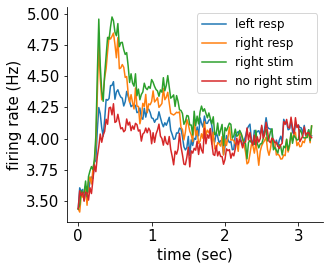

In [3]:
#@title basic plots of population average
from matplotlib import pyplot as plt
dt = 1 / 50 # binning at 20 ms

ax = plt.subplot(1,5,1)
response = dat['response_choice'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrastRight'] # 0 - low - high
vis_left = dat['contrastLeft'] # 0 - low - high
plt.plot(dt * np.arange(160), 1/dt * dat['spks_20ms'][:,response>=0].mean(axis=(0,1))) # left responses
plt.plot(dt * np.arange(160), 1/dt * dat['spks_20ms'][:,response<0].mean(axis=(0,1))) # right responses
plt.plot(dt * np.arange(160), 1/dt * dat['spks_20ms'][:,vis_right>0].mean(axis=(0,1))) # stimulus on the right
plt.plot(dt * np.arange(160), 1/dt * dat['spks_20ms'][:,vis_right==0].mean(axis=(0,1))) # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');

In [4]:
#@title groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
               ]

# not in this animals (but in others on figshare)
#  ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
#  ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
#  ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate

NN = len(dat['brain_region']) # number of neurons
barea = len(brain_groups) * np.ones(NN, ) # last one is "other"
for j in range(len(brain_groups)):
  barea[np.isin(dat['brain_region'], brain_groups[j])] = j # assign a number to each region

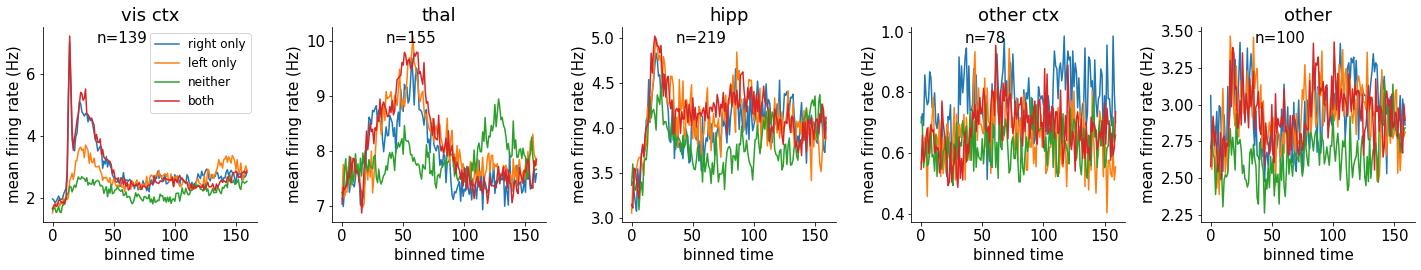

In [5]:
#@title plots by brain region and visual conditions
for j in range(len(brain_groups)+1):
  ax = plt.subplot(1,len(brain_groups)+1,j+1)
  plt.title(regions[j])
  
  plt.plot(1/dt *  dat['spks_20ms'][barea==j][:,np.logical_and(vis_left==0, vis_right>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_20ms'][barea==j][:,np.logical_and(vis_left>0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_20ms'][barea==j][:,np.logical_and(vis_left==0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_20ms'][barea==j][:,np.logical_and(vis_left>0, vis_right>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  #plt.plot(dat['spks_20ms'][barea==j][:,vis_right>0].mean(axis=(0,1)))
  #plt.plot(dat['spks_20ms'][barea==j][:,vis_right==0].mean(axis=(0,1)))

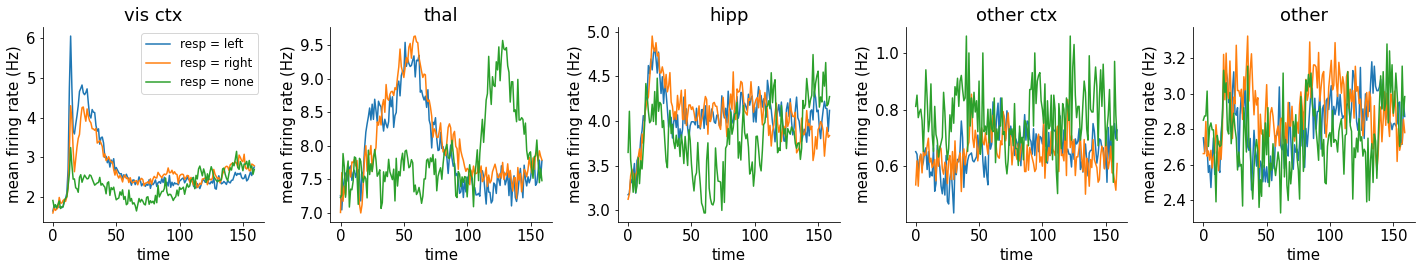

In [6]:
#@title plots by brain region and response type
for j in range(len(brain_groups)+1):
  ax = plt.subplot(1,len(brain_groups)+1,j+1)
  plt.title(regions[j])
  if np.sum(barea==j)==0:
    continue
  plt.plot(1/dt * dat['spks_20ms'][barea==j][:,response<0].mean(axis=(0,1)))  
  plt.plot(1/dt * dat['spks_20ms'][barea==j][:,response>0].mean(axis=(0,1)))
  plt.plot(1/dt * dat['spks_20ms'][barea==j][:,response==0].mean(axis=(0,1)))
 
  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=12)
  ax.set(xlabel = 'time', ylabel = 'mean firing rate (Hz)')


In [7]:
#@title top PC directions from stimulus + response period, with projections of the entire duration
from sklearn.decomposition import PCA 

droll = np.reshape(dat['spks_20ms'][:,:,1:80], (NN,-1)) # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components = 5).fit(droll.T)
W = model.components_
pc_20ms = W @ np.reshape(dat['spks_20ms'], (NN,-1))
pc_20ms = np.reshape(pc_20ms, (5, -1, 160))

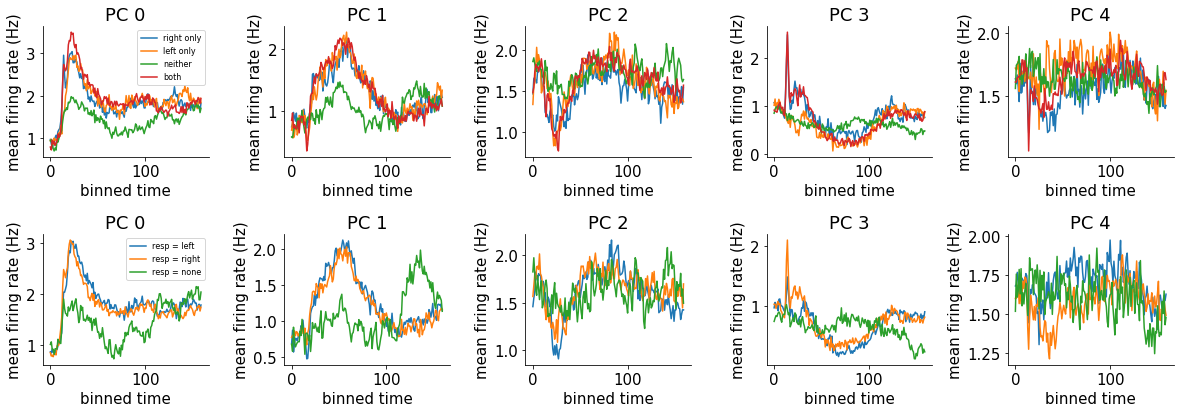

In [8]:
#@title The top PCs capture most variance across the brain. What do they care about? 
plt.figure(figsize= (20, 6))
for j in range(len(pc_20ms)):
  ax = plt.subplot(2,len(pc_20ms)+1,j+1)
  pc1 = pc_20ms[j]

  plt.plot(pc1[np.logical_and(vis_left==0, vis_right>0), :].mean(axis=0))  
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0))
   
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2,len(pc_20ms)+1,len(pc_20ms)+1 + j+1)
  
  plt.plot(pc1[response>0, :].mean(axis=0))  
  plt.plot(pc1[response<0, :].mean(axis=0))
  plt.plot(pc1[response==0, :].mean(axis=0))

  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

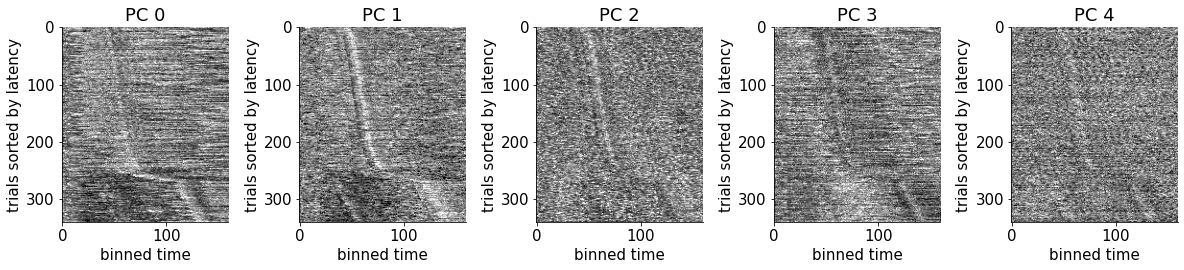

In [9]:
#@title now sort all trials by response latency and see if the PCs care about that.
from scipy.stats import zscore

isort = np.argsort(dat['resp_times'].flatten())

for j in range(len(pc_20ms)):
  ax = plt.subplot(1,len(pc_20ms)+1,j+1)
  pc1 = zscore(pc_20ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time', ylabel = 'trials sorted by latency')
  plt.title('PC %d'%j)

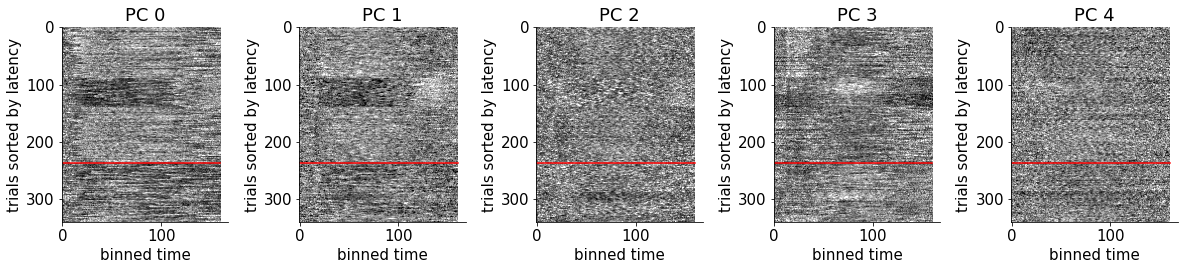

In [10]:
#@title correct vs incorrect trials
# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0

is_correct = np.sign(response)==np.sign(vis_left-vis_right)
isort = np.argsort(-is_correct.astype('float32') + response/10) # sort by correct, and then by response

nwrong = np.sum(is_correct)
for j in range(len(pc_20ms)):
  ax = plt.subplot(1,len(pc_20ms)+1,j+1)
  pc1 = zscore(pc_20ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time', ylabel = 'trials sorted by latency')
  plt.title('PC %d'%j)

  plt.plot([0, 160], [nwrong, nwrong], 'r')
